# Deep Learning for Article Classification with Publication using Kaggle Data

Here is the link for data - https://www.kaggle.com/snapcrack/all-the-news (courtesy of Andrew Thompson)

------------
**This is the third part. A brief about the objective and dataset is given below. In the first part, we are done with data cleaning, processing, and its splitting into train and test sets. In the second part, we implemented 1-dimensional CNN on sequence of 4, 6 & 8 word vectors and obtained an accuracy of 87%. In this part, we shall implement Bi-directional LSTM on a subset of feature data and compare performance with 1-D CNN**

**We are building a text classifier with Keras for the Kaggle dataset containing information such as title, author, publication and the content of the article. This data set includes several publications but we focus on top 5 publications (all US publishers) as labels acting for the title and content as features. Below is the description of labels.**

    Label	Description
    0	    Breitbart
    1	    New York Post
    2	    NPR (National Public Radio)
    3	    Washington Post
    4	    Reuters

In [1]:
## Importing relevant libraries

from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding, LSTM, TimeDistributed
from tensorflow.keras.layers import Bidirectional

from tensorflow.keras.callbacks import EarlyStopping

import tensorflow as tf

import pickle
import pandas as pd

**Importing the encoded files from part-2**

In [2]:
with open("./X_train_encoded.pkl", 'rb') as f:
    trainX = pickle.load(f)

In [3]:
with open("./X_test_encoded.pkl", 'rb') as f:
    testX = pickle.load(f)

In [4]:
length, vocab_size = 12052, 157706  # Values taken from above deduced variables

In [5]:
y_train_cat = pd.read_pickle("./y_train_cat.pkl").to_numpy()
y_test_cat = pd.read_pickle("./y_test_cat.pkl").to_numpy()

In [6]:
trainX.shape, testX.shape

((52183, 12052), (22365, 12052))

In [7]:
y_train_cat.shape, y_test_cat.shape

((52183, 5), (22365, 5))

**Setting maximum length of vector as 500**

In [9]:
max_len = 500

**The architecture of the model is given below. A brief explanation -**

An input shape of 500 length is chosen for each article which produces a 100 sized vector using the Embedding layer of each word

The bi-directional LSTM layer then runs on the vectors to learn the sequences from both ends (forwards and backwards)

The output is flattened and then fed to dense layers which finally produce the output of probability of 5 classes which get softmax activated finally

This is a very simple architecture and can be even experimented to find better results

In [10]:
input1 = Input(shape=(max_len,))

model = Embedding(vocab_size, 100, input_length=max_len)(input1)

model = Bidirectional (LSTM (128,return_sequences=True,dropout=0.50),merge_mode='concat')(model)

model = Flatten()(model)

model = Dense(10,activation='relu')(model)

output = Dense(5,activation='softmax')(model)

model = Model(input1,output)

model.compile(loss='categorical_crossentropy',optimizer='adam', metrics=['accuracy'])

In [11]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 500)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 500, 100)          15770600  
_________________________________________________________________
bidirectional (Bidirectional (None, 500, 256)          234496    
_________________________________________________________________
flatten (Flatten)            (None, 128000)            0         
_________________________________________________________________
dense (Dense)                (None, 10)                1280010   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 55        
Total params: 17,285,161
Trainable params: 17,285,161
Non-trainable params: 0
_________________________________________________

**An early stop mechanism applied that stops training when val_loss stops reducing**

In [12]:
earlystop = EarlyStopping(monitor='val_loss', patience=2)

**Fitting the model with 10 epochs and batch_size of 32**

In [13]:
model.fit(trainX[:, :max_len], y_train_cat, epochs = 10, batch_size = 32, validation_data=(testX[:, :max_len], y_test_cat), callbacks=[earlystop])

Epoch 1/10
1631/1631 [==============================] - 3027s 2s/step - loss: 0.8480 - accuracy: 0.6860 - val_loss: 0.3773 - val_accuracy: 0.8693
Epoch 2/10
1631/1631 [==============================] - 3020s 2s/step - loss: 0.1869 - accuracy: 0.9385 - val_loss: 0.4249 - val_accuracy: 0.8681
Epoch 3/10
1631/1631 [==============================] - 2280s 1s/step - loss: 0.0717 - accuracy: 0.9768 - val_loss: 0.5186 - val_accuracy: 0.8602


**Saving model and its weights**

In [30]:
model.save('trial2.h5')

model.save_weights('trial2_weights')

## Model Evaluation

In [15]:
loss_acc_hist = pd.DataFrame(model.history.history)
loss_acc_hist

,loss,accuracy,val_loss,val_accuracy
0,0.607174,0.786578,0.377319,0.869349
1,0.191740,0.935880,0.424902,0.868097
2,0.082179,0.972596,0.518565,0.860183


In [16]:
import matplotlib.pyplot as plt

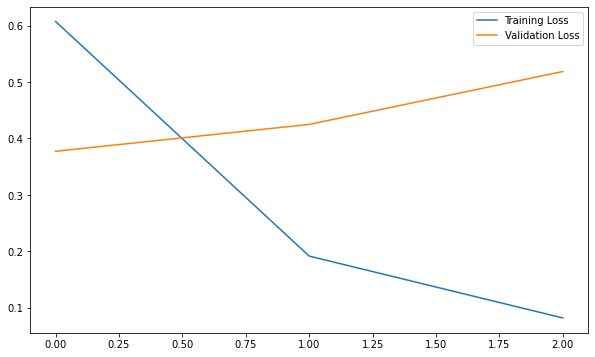

In [17]:
plt.figure(figsize=(10,6))
plt.plot(loss_acc_hist['loss'], label='Training Loss')
plt.plot( loss_acc_hist['val_loss'], label='Validation Loss')
plt.legend()

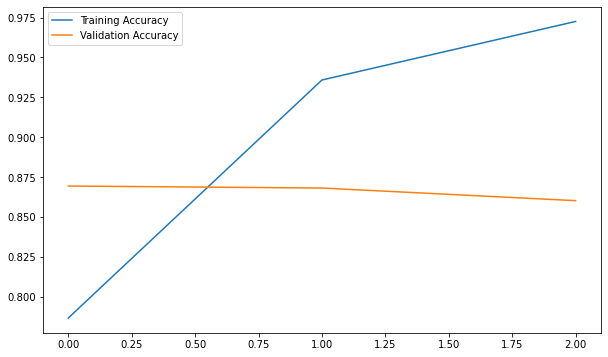

In [18]:
plt.figure(figsize=(10,6))
plt.plot(loss_acc_hist['accuracy'], label='Training Accuracy')
plt.plot( loss_acc_hist['val_accuracy'], label='Validation Accuracy')
plt.legend()

**Evaluating on Training Set**

In [19]:
loss_train, acc_train = model.evaluate(trainX[:, :max_len], y_train_cat)

1631/1631 [==============================] - 313s 192ms/step - loss: 0.0406 - accuracy: 0.9879


**Evaluating on Testing Set**

In [20]:
loss_test, acc_test = model.evaluate(testX[:, :max_len], y_test_cat)

699/699 [==============================] - 131s 188ms/step - loss: 0.5186 - accuracy: 0.8602


In [21]:
print("Testing accuracy is:", acc_test*100)

Testing accuracy is: 86.01832985877991


**Computing Model's classification report and confusion Matrix**

In [23]:
import numpy as np

In [24]:
predictions = np.argmax(model.predict(testX[:, :max_len]), axis=-1)

In [25]:
from sklearn.metrics import classification_report, confusion_matrix

In [26]:
y_test = np.argmax(y_test_cat, axis=-1)

In [27]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91      7099
           1       0.82      0.75      0.78      3494
           2       0.88      0.78      0.82      5244
           3       0.99      0.96      0.97      3213
           4       0.75      0.82      0.78      3315

    accuracy                           0.86     22365
   macro avg       0.86      0.85      0.85     22365
weighted avg       0.86      0.86      0.86     22365



In [28]:
import seaborn as sns
import matplotlib.pyplot as plt

<AxesSubplot:>

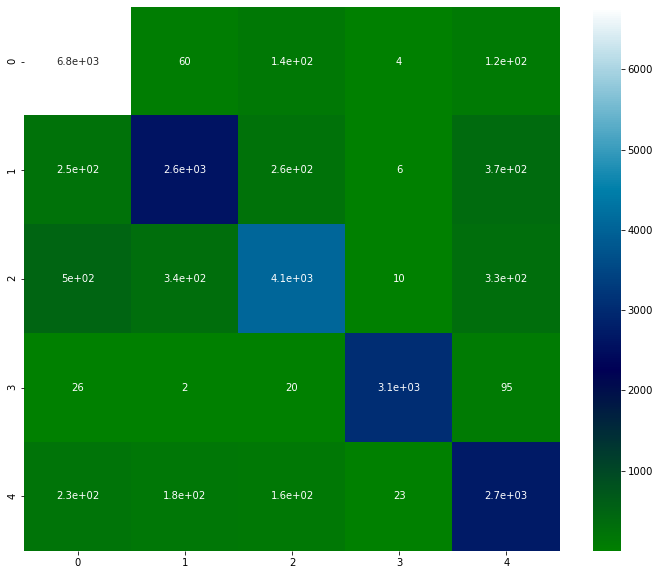

In [29]:
plt.figure(figsize=(12,10))
sns.heatmap(confusion_matrix(y_test, predictions), annot=True, cmap='ocean')

**The model has performed quite well (with some over-fitting maybe). No hyper-parameter tuning was involved though**

**The performance is quite comparable with 1-D CNN model implemented in part-2**

**This concludes the application of Text Classification with Bi-directional LSTM with simultaneous training of inputs (as Embedding layer)**

**The results show that publications (and their authors) write titles and the articles in their own unique way which is quite distinctive from each other. The sequence of words being captured shows this!**